# Gram-schmidt and the KF

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/var/folders/vf/3b13gs616172kztlr53t6_s00000gn/T/ipykernel_90254/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
import seaborn as sns
sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [4]:
%config InlineBackend.figure_format = "retina"

## Best linear unbiased predictor for $a$

In [5]:
np.random.seed(3141)

n_samples = 1_000
# n_trials = 30
a = 2.5
y = np.random.randn(n_samples) * 0.1
e = np.random.randn(n_samples) * 1.0 
f = a * y + e

In [6]:
cov = np.cov(f, y, ddof=0, rowvar=False)
cov

array([[1.07501336, 0.02130866],
       [0.02130866, 0.010121  ]])

In [7]:
cov_fy = cov[0, 1]
var_y = cov[1, 1]
var_f = cov[0, 0]

In [8]:
# Best linear unbiased predictor
blup = cov_fy / var_y
blup

2.1053912229598666

In [9]:
# Error covariance matrix
var_blup = var_f - blup ** 2 * var_y
np.sqrt(var_blup)

1.0149632052763964

## 2d example

In [10]:
np.set_printoptions(suppress=True)

In [320]:
np.random.seed(314)
n_samples = 1000

C = np.array([5, -5])
f = np.random.randn(n_samples, 2)
e = np.random.randn(n_samples) * 1.0

y = np.einsum("m,sm->s", C, f) + e # signal + noise

In [321]:
cov = np.cov(np.c_[f, y], rowvar=False)
cov

array([[ 1.03637422, -0.03071531,  5.31737454],
       [-0.03071531,  1.02426086, -5.25233804],
       [ 5.31737454, -5.25233804, 53.69804633]])

In [322]:
Aopt = cov[-1, :2] / cov[-1, -1]
Aopt

array([ 0.09902361, -0.09781246])

In [319]:
fhat = np.einsum("s,m->sm", y, Aopt)

In [311]:
cov[:2, :2] - np.outer(Aopt, Aopt) / var_y

array([[0.06752923, 0.92627979],
       [0.92627979, 0.07897071]])

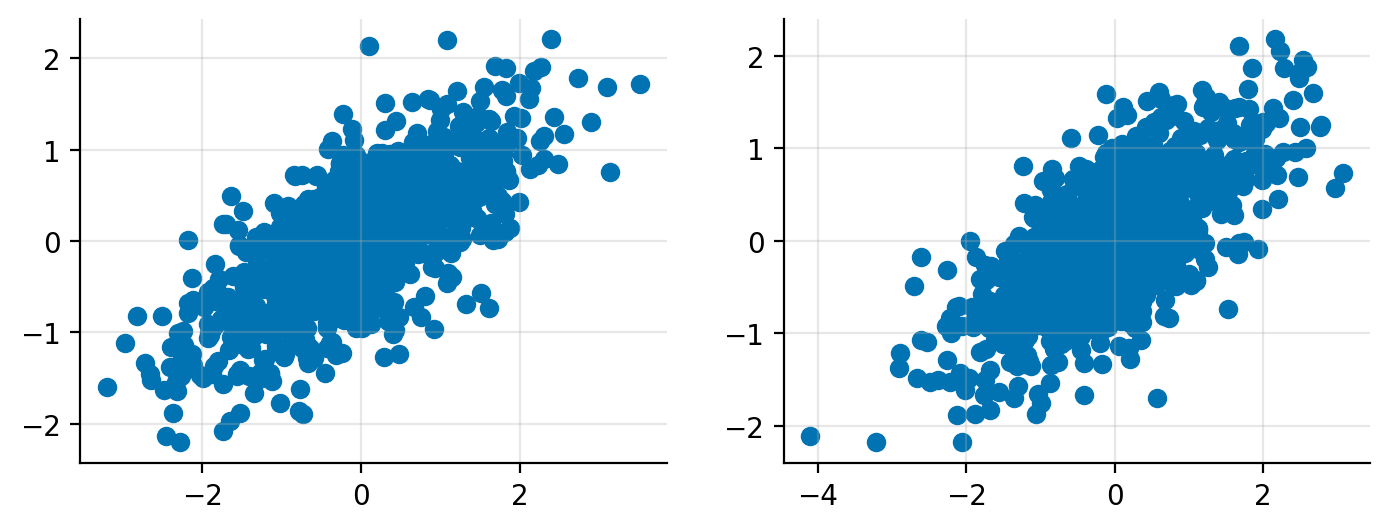

In [312]:
fig, axs = plt.subplots(1, 2, figsize=(6.4 * 1.3, 4.8 * 0.6))
for ix, ax in enumerate(axs):
    ax.scatter(f[:, ix], fhat[:, ix])
    ax.grid(alpha=0.3)